In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


train_dataset = datasets.MNIST(root='MNIST/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='MNIST/', train=False, download=True, transform=transform)



train_images = train_dataset.data.float().div(255).view(-1, 28 * 28).to(device)
train_labels = train_dataset.targets.to(device)
test_images = test_dataset.data.float().div(255).view(-1, 28 * 28).to(device)
test_labels = test_dataset.targets.to(device)

In [ ]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [4]:

model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)


In [5]:

num_epochs = 10000
batch_size = 4096
num_samples = train_images.shape[0]

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        
        batch_images = train_images[i:i + batch_size]
        batch_labels = train_labels[i:i + batch_size]
          
        outputs = model(batch_images)
           
        loss = loss_fn(outputs, batch_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
   
    scheduler.step()
    
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/10000], Loss: 0.4999
Epoch [200/10000], Loss: 0.2932
Epoch [300/10000], Loss: 0.2399
Epoch [400/10000], Loss: 0.2142
Epoch [500/10000], Loss: 0.1953
Epoch [600/10000], Loss: 0.1800
Epoch [700/10000], Loss: 0.1663
Epoch [800/10000], Loss: 0.1540
Epoch [900/10000], Loss: 0.1433
Epoch [1000/10000], Loss: 0.1338
Epoch [1100/10000], Loss: 0.1261
Epoch [1200/10000], Loss: 0.1193
Epoch [1300/10000], Loss: 0.1131
Epoch [1400/10000], Loss: 0.1072
Epoch [1500/10000], Loss: 0.1018
Epoch [1600/10000], Loss: 0.0977
Epoch [1700/10000], Loss: 0.0939
Epoch [1800/10000], Loss: 0.0904
Epoch [1900/10000], Loss: 0.0873
Epoch [2000/10000], Loss: 0.0844
Epoch [2100/10000], Loss: 0.0819
Epoch [2200/10000], Loss: 0.0797
Epoch [2300/10000], Loss: 0.0775
Epoch [2400/10000], Loss: 0.0755
Epoch [2500/10000], Loss: 0.0736
Epoch [2600/10000], Loss: 0.0721
Epoch [2700/10000], Loss: 0.0706
Epoch [2800/10000], Loss: 0.0692
Epoch [2900/10000], Loss: 0.0678
Epoch [3000/10000], Loss: 0.0665
Epoch [3100/10000],

In [6]:

def evaluate_model(model, test_images, test_labels, batch_size=4096):
    model.eval()  
    all_preds = []
    all_labels = []
    
    num_samples = test_images.shape[0] 
    with torch.no_grad():  
        for i in range(0, num_samples, batch_size):
            
            batch_images = test_images[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]
            
            
            outputs = model(batch_images)
            
            
            _, predicted = torch.max(outputs, 1)
            
           
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    return all_preds, all_labels


all_preds, all_labels = evaluate_model(model, test_images, test_labels)


f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

Accuracy: 0.9666, F1 Score: 0.9666


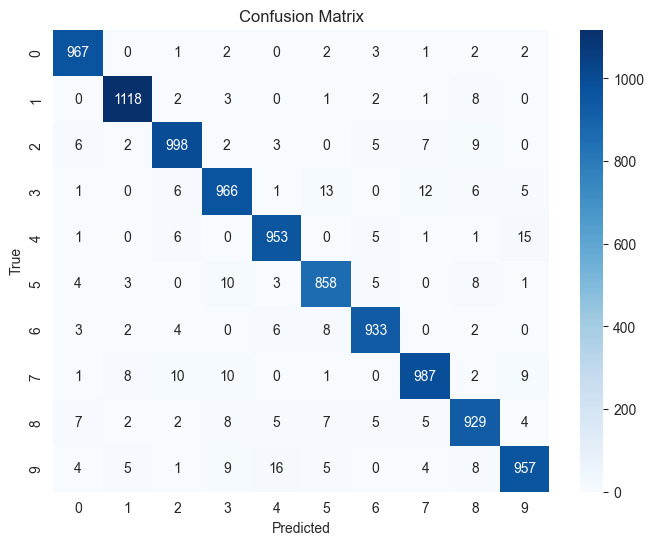

In [7]:


print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:



train_images_cpu = train_images.cpu().numpy()
train_labels_cpu = train_labels.cpu().numpy()
test_images_cpu = test_images.cpu().numpy()
test_labels_cpu = test_labels.cpu().numpy()


lr = LogisticRegression(max_iter=500)
lr.fit(train_images_cpu, train_labels_cpu)
lr_preds = lr.predict(test_images_cpu)
lr_f1 = f1_score(test_labels_cpu, lr_preds, average='weighted')
print(f'Logistic Regression F1 Score: {lr_f1:.4f}')


rf = RandomForestClassifier()
rf.fit(train_images_cpu, train_labels_cpu)
rf_preds = rf.predict(test_images_cpu)
rf_f1 = f1_score(test_labels_cpu, rf_preds, average='weighted')
print(f'Random Forest F1 Score: {rf_f1:.4f}')

Logistic Regression F1 Score: 0.9260
Random Forest F1 Score: 0.9702


In [9]:
lr_cm = confusion_matrix(test_labels_cpu, lr_preds)
rf_cm = confusion_matrix(test_labels_cpu, rf_preds)


MLP F1 Score: 0.9666
Logistic Regression F1 Score: 0.9260
Random Forest F1 Score: 0.9691


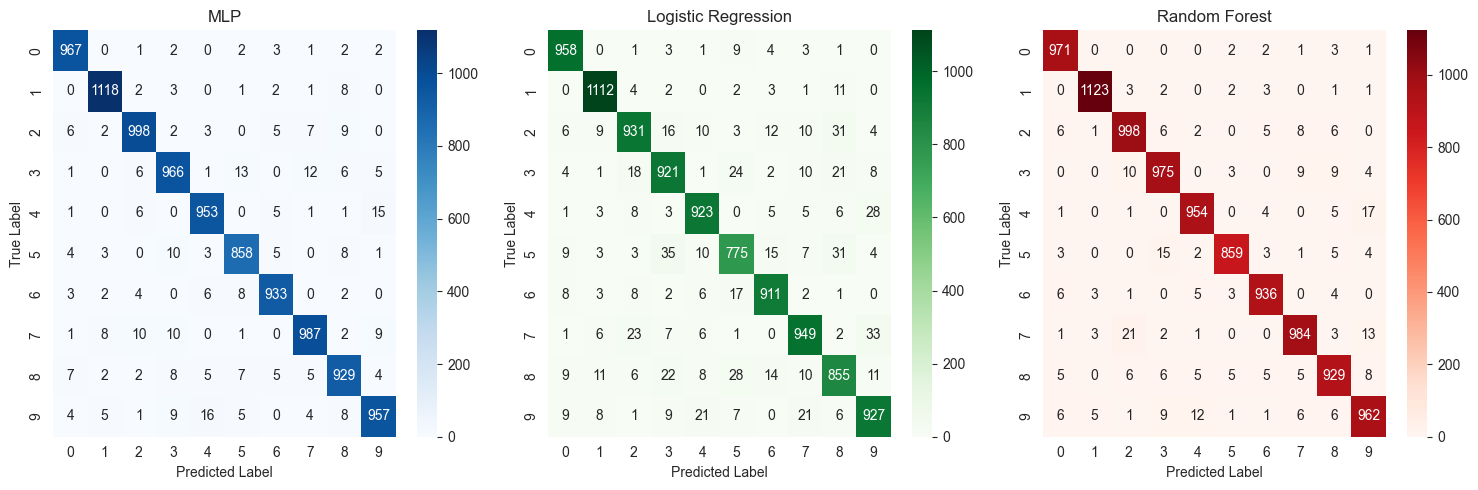

In [10]:
print(f'MLP F1 Score: {f1:.4f}')
print(f'Logistic Regression F1 Score: {lr_f1:.4f}')
print(f'Random Forest F1 Score: {rf_f1:.4f}')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("MLP")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Logistic Regression")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Reds", ax=axes[2])
axes[2].set_title("Random Forest")
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [11]:
common_confusions = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 10 and rf_cm[i, j] > 10 and lr_cm[i, j] > 10:
            common_confusions.append((i, j))

In [12]:
print(common_confusions)

[(4, 9), (9, 4)]


Logistic regression has a lower F1 score than MLP and Random Forest. This suggests that the MLP and Random Forest handle the MNIST dataset better than Logistic Regression, possibly due to their capability to capture non-linear relationships.  
In the Logistic Regression confusion matrix, there’s a noticeable confusion between many digits. In the MLP and Random Forest confusion matrices, these confusions are less pronounced, though there are still some similar misclassifications but at lower counts.
Digits (4,9) and (8,3) are commonly confused in all models.

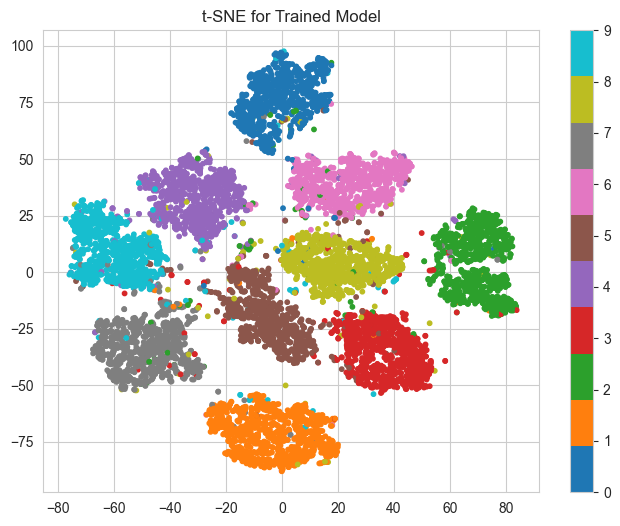

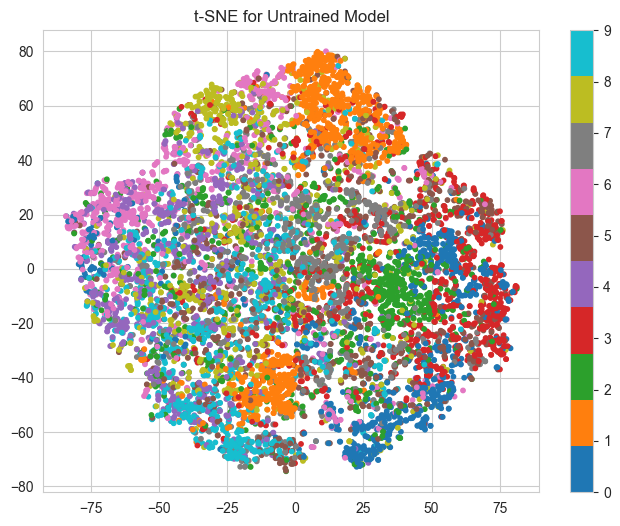

In [13]:



def plot_tsne(model, data, labels, layer_idx, title):
    model.eval()
    with torch.no_grad():
        if layer_idx == 2:
            features = torch.relu(model.fc1(data))
        elif layer_idx == 3:
            features = torch.relu(model.fc2(torch.relu(model.fc1(data))))
        
        tsne = TSNE(n_components=2, random_state=42)
        tsne_features = tsne.fit_transform(features.cpu().numpy())
        
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels.cpu().numpy(), cmap='tab10', s=10)
        plt.colorbar(scatter)
        plt.title(title)
        plt.show()


plot_tsne(model, test_images, test_labels, layer_idx=3, title='t-SNE for Trained Model')


untrained_model = MLP().to(device)
plot_tsne(untrained_model, test_images, test_labels, layer_idx=3, title='t-SNE for Untrained Model')



The first plot shows well-separated clusters corresponding to each digit class, suggesting that the trained MLP has learned a meaningful representation of the digit images. The second plot displays a more scattered distribution with no distinct clusters, which indicates that the untrained model does not have meaningful embeddings for separating the digit classes.

In [14]:
fashion_test_dataset = datasets.FashionMNIST(root='MNIST/', train=False, download=True, transform=transform)
fashion_test_images = fashion_test_dataset.data.float().div(255).view(-1, 28 * 28).to(device)
fashion_test_labels = fashion_test_dataset.targets.to(device)

evaluate_model(model, fashion_test_images, fashion_test_labels)

all_preds, all_labels = evaluate_model(model, fashion_test_images, fashion_test_labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')


f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.1280
F1 Score: 0.0718


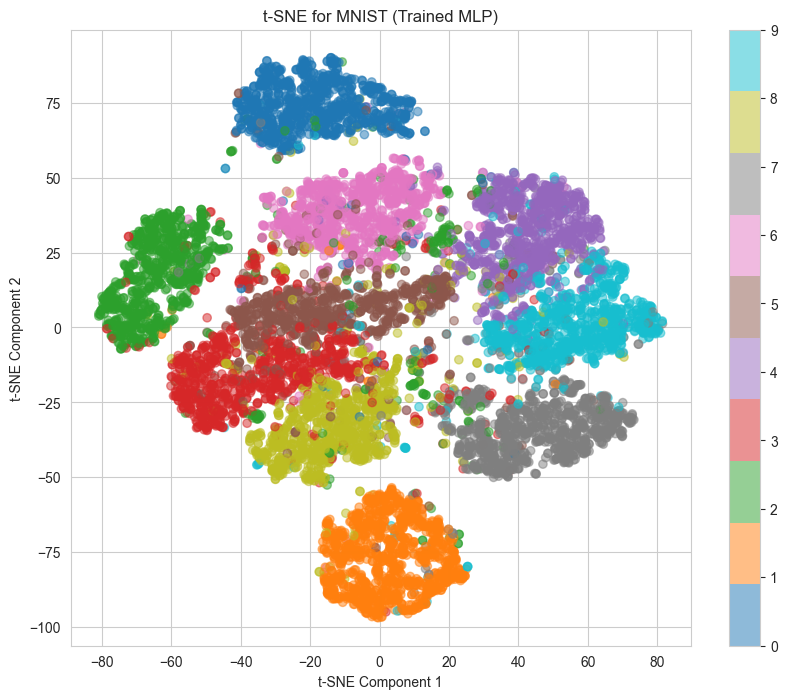

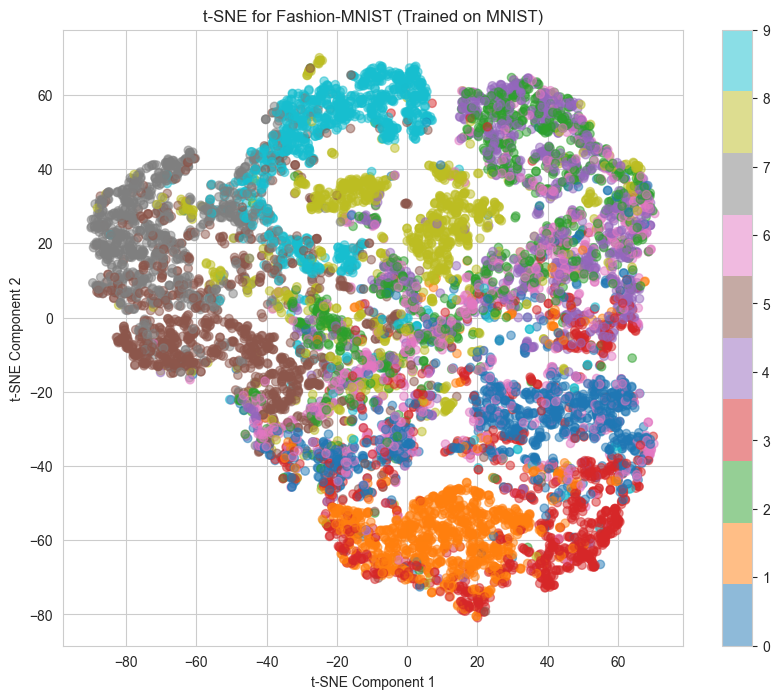

In [15]:


def plot_tsne(model, data, labels, title):
    model.eval()
    with torch.no_grad():
        
        features = model.fc2(model.fc1(data)).cpu().numpy()  # Extract features from the second layer
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

plot_tsne(model, test_images, test_labels, title='t-SNE for MNIST (Trained MLP)')



plot_tsne(model, fashion_test_images, fashion_test_labels, title='t-SNE for Fashion-MNIST (Trained on MNIST)')



When applying the trained MLP on Fashion-MNIST, the embeddings in the second layer's t-SNE plot may show less clear clustering compared to MNIST. This is because Fashion-MNIST consists of different object categories (clothing items) rather than digits, and the MNIST-trained MLP may not have learned features that generalize well to these new categories. Consequently, the clusters might be less distinct, and there may be more overlap between classes.
